# **Important Libraries**

In [1]:
!pip uninstall -y scikit-learn imbalanced-learn numpy scipy
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1 numpy==1.23.5 scipy==1.10.1 --no-cache-dir

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: imbalanced-learn 0.10.1
Uninstalling imbalanced-learn-0.10.1:
  Successfully uninstalled imbalanced-learn-0.10.1
Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Found existing installation: scipy 1.10.1
Uninstalling scipy-1.10.1:
  Successfully uninstalled scipy-1.10.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 190.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 268.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 263.0 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 116.9 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages

In [19]:
import pandas as pd
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="threadpoolctl")

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

# **Load Dataset & Preprocessing**

In [3]:
df = pd.read_csv("/kaggle/input/spam-text-message-classification/SPAM text message 20170820 - Data.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
X = df["Message"]
y = df["Category"]

In [6]:
# unbalanced dataset
y.value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [7]:
# Encode Category
y = y.map({"ham":0,"spam":1})
y

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: Category, Length: 5572, dtype: int64

In [8]:
# Preprocess the Text
def normalize_text_spacy(text):
    # Convert to lower case
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove email address
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # process the text using spaCy
    doc = nlp(text)
    # Remove stopwords, numeric tokens, punctuation, and lemmatize tokens
    normalized_tokens = [
        token.lemma_ for token in doc
        if token.text not in STOP_WORDS
        and not token.is_punct
        and not token.like_num
        and token.is_alpha
    ]
    # Join tokens back into a single string
    return ' '.join(normalized_tokens)

In [9]:
X = X.apply(normalize_text_spacy)
X.head()

0    jurong point crazy available bugis n great wor...
1                              ok lar joking wif u oni
2    free entry wkly comp win fa cup final tkts st ...
3                                  u dun early hor u c
4                            nah not think go usf live
Name: Message, dtype: object

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y)

In [11]:
# apply vectorizatin
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [12]:
# Handle Imbalance Dataset
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f5a8e7df6a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


# **Model**

In [13]:
model = MultinomialNB()
model.fit(X_train_resampled, y_train_resampled)

MultinomialNB()

# **Evaluate the Model**

In [15]:
y_pred = model.predict(X_test)
accuracy_score(y_test,y_pred)

0.9452914798206278

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       966
           1       0.74      0.92      0.82       149

    accuracy                           0.95      1115
   macro avg       0.86      0.93      0.89      1115
weighted avg       0.95      0.95      0.95      1115



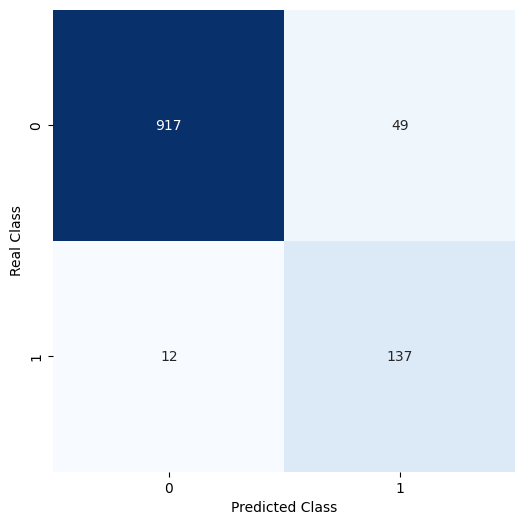

In [20]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()